In this competition we were given a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company.

It was asked to predict total sales for every product and store in the next month.

The evaluation metric was RMSE where True target values are clipped into [0,20] range.

The main thing that I noticed was that the data preparation aspect of this competition was by far the most important thing. I creted a variety of features.


###############################################################################

Sales Train: Contains daily historical data from January 2013 to October 2015 including date, shop_id, item_id, item_price, and item_cnt_day (the number of products sold).

Test: Contains the ID (representing a (Shop, Item) tuple), shop_id, and item_id. I need to forecast the total amount of these products sold for November 2015.

Sample Submission: Shows the expected submission format with ID and item_cnt_month (your predictions).

Items: Includes item_name, item_id, and item_category_id, providing details about the items/products.

Item Categories: Includes item_category_name and item_category_id, offering information about item categories.

Shops: Contains shop_name and shop_id, providing details about the shops.


1. Preliminary Data Exploration and Cleaning
Load the datasets: Load sales_train.csv, test.csv, items.csv, item_categories.csv, and shops.csv.
Basic checks: Ensure that there are no missing or duplicate values. Check the data types of each column, especially the date column in sales_train.csv, to ensure it's in datetime format.

In [26]:
import pandas as pd
import numpy as np

# Load datasets
sales_train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
items = pd.read_csv('data/items.csv')
item_categories = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

# Basic Checks
# Checking for missing values
missing_values = {
    'sales_train': sales_train.isnull().sum(),
    'test': test.isnull().sum(),
    'items': items.isnull().sum(),
    'item_categories': item_categories.isnull().sum(),
    'shops': shops.isnull().sum()
}

# Checking for duplicates
duplicates = {
    'sales_train': sales_train.duplicated().sum(),
    'test': test.duplicated().sum(),
    'items': items.duplicated().sum(),
    'item_categories': item_categories.duplicated().sum(),
    'shops': shops.duplicated().sum()
}

# Data types check
data_types = {
    'sales_train': sales_train.dtypes,
    'test': test.dtypes,
    'items': items.dtypes,
    'item_categories': item_categories.dtypes,
    'shops': shops.dtypes
}

missing_values, duplicates, data_types


({'sales_train': date              0
  date_block_num    0
  shop_id           0
  item_id           0
  item_price        0
  item_cnt_day      0
  dtype: int64,
  'test': ID         0
  shop_id    0
  item_id    0
  dtype: int64,
  'items': item_name           0
  item_id             0
  item_category_id    0
  dtype: int64,
  'item_categories': item_category_name    0
  item_category_id      0
  dtype: int64,
  'shops': shop_name    0
  shop_id      0
  dtype: int64},
 {'sales_train': 6, 'test': 0, 'items': 0, 'item_categories': 0, 'shops': 0},
 {'sales_train': date               object
  date_block_num      int64
  shop_id             int64
  item_id             int64
  item_price        float64
  item_cnt_day      float64
  dtype: object,
  'test': ID         int64
  shop_id    int64
  item_id    int64
  dtype: object,
  'items': item_name           object
  item_id              int64
  item_category_id     int64
  dtype: object,
  'item_categories': item_category_name    object
 

In [27]:
# Count the number of duplicate rows
for df_name, num_duplicates in duplicates.items():
    print(f"Number of duplicates in {df_name}: {num_duplicates}")

sales_train=sales_train.drop_duplicates()
num_duplicates = sales_train.duplicated().sum()
print(num_duplicates)

Number of duplicates in sales_train: 6
Number of duplicates in test: 0
Number of duplicates in items: 0
Number of duplicates in item_categories: 0
Number of duplicates in shops: 0
0


In [28]:

for df_name, num_missing_values in missing_values.items():
    if num_missing_values.any():  # Check if any missing values exist
        print(f"Number of missing values in {df_name}:")
        print(num_missing_values)


In [32]:
# Define outliers in the sales data as values beyond the 99th percentile
outlier_threshold = sales_train['item_cnt_day'].quantile(0.99)
# Count the number of values in 'item_cnt_day' column that are greater than the outlier threshold
num_data = (sales_train['item_cnt_day']).sum()
num_outliers = (sales_train['item_cnt_day'] > outlier_threshold).sum()

print("Number of data points:", num_data)
print("Number of values greater than the outlier threshold:", num_outliers)

# Calculate the percentage
percentage_outliers = (num_outliers / num_data) * 100

print("Percentage of data points greater than the outlier threshold:", percentage_outliers, "%")



Number of data points: 3648200.0
Number of values greater than the outlier threshold: 27411
Percentage of data points greater than the outlier threshold: 0.7513568335069349 %


In [5]:
# Convert date to datetime format
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')

# Define outliers in the sales data as values beyond the 99th percentile
outlier_threshold = sales_train['item_cnt_day'].quantile(0.99)

# Clip the outliers in the sales data
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].clip(0, outlier_threshold)

# Join the item categories with the sales data
sales_train = sales_train.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

# Aggregate sales data to monthly level
monthly_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    item_cnt_month=pd.NamedAgg(column='item_cnt_day', aggfunc='sum'),
    avg_item_price=pd.NamedAgg(column='item_price', aggfunc='mean')  # Average price for the month might be a useful feature
).reset_index()

monthly_sales


,date_block_num,shop_id,item_id,item_cnt_month,avg_item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5
...,...,...,...,...,...
1609119,33,59,22087,6.0,119.0
1609120,33,59,22088,2.0,119.0
1609121,33,59,22091,1.0,179.0
1609122,33,59,22100,1.0,629.0


1. **Capture Temporal Dependencies**: Lag features are crucial in time series forecasting because they help the model understand and learn from the temporal dependencies in the data.
2. **Incorporate Historical Context**: They provide a simple way to incorporate historical context into the model, allowing the model to use past information to make future predictions.

   - Directly use the value from a previous time step.
   - Are singular points from the past.


In [6]:
# Function to create lag features for given lags and column
def create_lag_features(df, lags, column):
    for lag in lags:
        df[f'{column}_lag_{lag}'] = df.groupby(['shop_id', 'item_id'])[column].shift(lag)
    return df

# Define the lags we are interested in
lags = [1, 2, 3, 6, 12]
monthly_sales = create_lag_features(monthly_sales, lags, 'item_cnt_month')

monthly_sales  # Displaying rows to show some of the lagged features (they will be NaN initially)


,date_block_num,shop_id,item_id,item_cnt_month,avg_item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,32,6.0,221.0,NaN,NaN,NaN,NaN,NaN
1,0,0,33,3.0,347.0,NaN,NaN,NaN,NaN,NaN
2,0,0,35,1.0,247.0,NaN,NaN,NaN,NaN,NaN
3,0,0,43,1.0,221.0,NaN,NaN,NaN,NaN,NaN
4,0,0,51,2.0,128.5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,119.0,3.0,2.0,5.0,2.0,6.0
1609120,33,59,22088,2.0,119.0,1.0,7.0,7.0,3.0,7.0
1609121,33,59,22091,1.0,179.0,3.0,1.0,1.0,1.0,1.0
1609122,33,59,22100,1.0,629.0,1.0,NaN,NaN,NaN,NaN


In [7]:
# Step 1: Handle NaN Values in Lag Features
monthly_sales.fillna(0, inplace=True)

# Step 2: Analyze Lag Features - check correlation with the target variable
correlation_matrix = monthly_sales[['item_cnt_month'] + [f'item_cnt_month_lag_{lag}' for lag in lags]].corr()
correlation_with_target = correlation_matrix['item_cnt_month'].sort_values(ascending=False)

correlation_with_target


item_cnt_month           1.000000
item_cnt_month_lag_1     0.658801
item_cnt_month_lag_2     0.534394
item_cnt_month_lag_3     0.482160
item_cnt_month_lag_6     0.411589
item_cnt_month_lag_12    0.330778
Name: item_cnt_month, dtype: float64

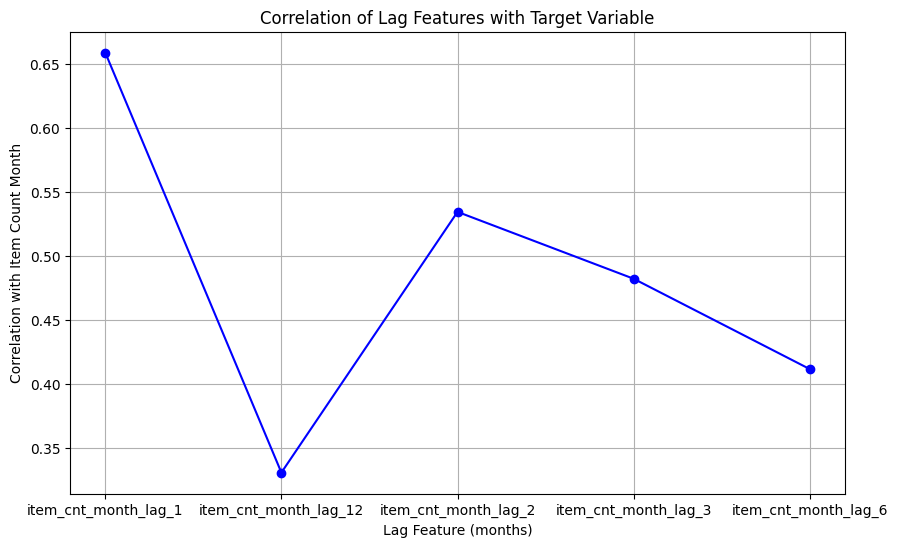

In [8]:
import matplotlib.pyplot as plt

# Extracting lag feature names and their correlations
lags_corr = correlation_with_target.drop('item_cnt_month').sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(lags_corr.index, lags_corr.values, marker='o', linestyle='-', color='b')
plt.title('Correlation of Lag Features with Target Variable')
plt.xlabel('Lag Feature (months)')
plt.ylabel('Correlation with Item Count Month')
plt.grid(True)
#plt.xticks(range(1, max(lags) + 1))  # Set x-ticks to be the lag months
plt.show()


In [9]:
# Step 1: Drop 12-Month Lag Feature
monthly_sales.drop('item_cnt_month_lag_12', axis=1, inplace=True)

# Step 2: Create Rolling Window Feature - rolling mean of the past 3 months
monthly_sales['item_cnt_month_roll_mean_3'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_month'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

monthly_sales


,date_block_num,shop_id,item_id,item_cnt_month,avg_item_price,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_roll_mean_3
0,0,0,32,6.0,221.0,0.0,0.0,0.0,0.0,6.000000
1,0,0,33,3.0,347.0,0.0,0.0,0.0,0.0,3.000000
2,0,0,35,1.0,247.0,0.0,0.0,0.0,0.0,1.000000
3,0,0,43,1.0,221.0,0.0,0.0,0.0,0.0,1.000000
4,0,0,51,2.0,128.5,0.0,0.0,0.0,0.0,2.000000
...,...,...,...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,119.0,3.0,2.0,5.0,2.0,3.666667
1609120,33,59,22088,2.0,119.0,1.0,7.0,7.0,3.0,3.333333
1609121,33,59,22091,1.0,179.0,3.0,1.0,1.0,1.0,1.666667
1609122,33,59,22100,1.0,629.0,1.0,0.0,0.0,0.0,1.000000


In [10]:
# Find the last month in the data
last_month = monthly_sales['date_block_num'].max()

# Split the data into training and validation sets
# Adjust the condition to include the last two months in the validation set
train_set = monthly_sales[monthly_sales['date_block_num'] < last_month - 2]
validation_set = monthly_sales[monthly_sales['date_block_num'] >= last_month - 2]


# Display the shapes of the datasets as a sanity check
train_set.shape, validation_set.shape


((1514429, 10), (94695, 10))

In [11]:
test = pd.read_csv('data/test.csv')
# Prepare the test set with correct lag features
test['date_block_num'] = last_month + 1

lags=[1,2,3,6]
for lag in lags:
    # Create a temporary DataFrame with lag features from the training data
    lag_features = monthly_sales[['date_block_num', 'shop_id', 'item_id', f'item_cnt_month_lag_{lag}']].copy()
    lag_features['date_block_num'] += lag  # Shift the date_block_num by the lag amount, safely in a copy
    
    # Rename the lagged column to prevent merge conflicts
    lag_features.rename({f'item_cnt_month_lag_{lag}': f'item_cnt_month_lag_{lag}'}, axis=1, inplace=True)
    
    # Check for any pre-existing columns in the test DataFrame and drop them to prevent duplicates
    #cols_to_drop = [col for col in lag_features.columns if col in test.columns and col not in ['date_block_num', 'shop_id', 'item_id']]
    #lag_features.drop(cols_to_drop, axis=1, inplace=True)

    # Merge lag features into the test set
    test = pd.merge(test, lag_features, on=['date_block_num', 'shop_id', 'item_id'], how='left')

test = test.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
# Fill missing values with 0
test.fillna(0, inplace=True)

# Display the first few rows of the test set to ensure the merge was successful
test


,ID,shop_id,item_id,date_block_num,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_category_id
0,0,5,5037,34,0.0,1.0,1.0,0.0,19
1,1,5,5320,34,0.0,0.0,0.0,0.0,55
2,2,5,5233,34,3.0,2.0,0.0,0.0,19
3,3,5,5232,34,0.0,0.0,0.0,0.0,23
4,4,5,5268,34,0.0,0.0,0.0,0.0,20
...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,1.0,0.0,0.0,0.0,55
214196,214196,45,16188,34,0.0,0.0,0.0,0.0,64
214197,214197,45,15757,34,0.0,0.0,0.0,0.0,55
214198,214198,45,19648,34,0.0,0.0,0.0,0.0,40


In [12]:
# Step 1: Get the Last 2 Months of Sales Data from Training Set
last_2_months_sales = monthly_sales[monthly_sales['date_block_num'].isin([last_month - 2, last_month])][['shop_id', 'item_id', 'item_cnt_month']]

# Step 2: Create a Placeholder for the Current Month's Sales Data in Test Set
test['item_cnt_month'] = 0  # Placeholder, you might choose to handle this differently

# Step 3: Append the Test Set to the Historical Data
combined_data = pd.concat([last_2_months_sales, test[['shop_id', 'item_id', 'item_cnt_month']]], ignore_index=True)

# Step 4: Calculate the Rolling Mean
combined_data['item_cnt_month_roll_mean_3'] = combined_data.groupby(['shop_id', 'item_id'])['item_cnt_month'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Step 5: Extract the Rolling Mean for the Test Set
# We're interested in the rolling mean for the current month (the placeholder month) for each (shop, item) pair
test['item_cnt_month_roll_mean_3'] = combined_data.groupby(['shop_id', 'item_id'])['item_cnt_month_roll_mean_3'].tail(1).reset_index(drop=True)

####Adding avg_item_price
# Step 1: Compute the average item price for each (shop, item) pair from the training data
avg_item_price = sales_train.groupby(['shop_id', 'item_id'])['item_price'].mean().reset_index()
avg_item_price.rename(columns={'item_price': 'avg_item_price'}, inplace=True)

# Step 2: Merge this average price with the test set
test = pd.merge(test, avg_item_price, on=['shop_id', 'item_id'], how='left')

# Handling missing values if any (e.g., if a (shop, item) pair in the test set was not present in the training set)
# You can fill missing values with a global average, or some other reasonable value depending on your analysis
test['avg_item_price'].fillna(test['avg_item_price'].mean(), inplace=True)

test


,ID,shop_id,item_id,date_block_num,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_category_id,item_cnt_month,item_cnt_month_roll_mean_3,avg_item_price
0,0,5,5037,34,0.0,1.0,1.0,0.0,19,0,6.0,1633.692308
1,1,5,5320,34,0.0,0.0,0.0,0.0,55,0,1.0,993.376819
2,2,5,5233,34,3.0,2.0,0.0,0.0,19,0,1.0,865.666667
3,3,5,5232,34,0.0,0.0,0.0,0.0,23,0,1.0,599.000000
4,4,5,5268,34,0.0,0.0,0.0,0.0,20,0,1.0,993.376819
...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,1.0,0.0,0.0,0.0,55,0,0.0,187.888889
214196,214196,45,16188,34,0.0,0.0,0.0,0.0,64,0,0.0,993.376819
214197,214197,45,15757,34,0.0,0.0,0.0,0.0,55,0,0.0,199.000000
214198,214198,45,19648,34,0.0,0.0,0.0,0.0,40,0,0.0,993.376819


In [13]:
ID=test.ID
test


,ID,shop_id,item_id,date_block_num,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_category_id,item_cnt_month,item_cnt_month_roll_mean_3,avg_item_price
0,0,5,5037,34,0.0,1.0,1.0,0.0,19,0,6.0,1633.692308
1,1,5,5320,34,0.0,0.0,0.0,0.0,55,0,1.0,993.376819
2,2,5,5233,34,3.0,2.0,0.0,0.0,19,0,1.0,865.666667
3,3,5,5232,34,0.0,0.0,0.0,0.0,23,0,1.0,599.000000
4,4,5,5268,34,0.0,0.0,0.0,0.0,20,0,1.0,993.376819
...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,34,1.0,0.0,0.0,0.0,55,0,0.0,187.888889
214196,214196,45,16188,34,0.0,0.0,0.0,0.0,64,0,0.0,993.376819
214197,214197,45,15757,34,0.0,0.0,0.0,0.0,55,0,0.0,199.000000
214198,214198,45,19648,34,0.0,0.0,0.0,0.0,40,0,0.0,993.376819


In [14]:
import numpy as np
import xgboost as xgb

# Prepare the data
# Prepare the feature matrix (X) and target vector (y) for the training set
# Dropping 'item_cnt_month' as it's the target variable, and 'date_block_num' as it's an index, not a feature
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
y_train = train_set['item_cnt_month']

# Prepare the feature matrix (X) and target vector (y) for the validation set
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
y_validation = validation_set['item_cnt_month']

# Convert to DMatrix - XGBoost's optimized data structure
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_validation, label=y_validation)

# Define the model
xgb_model = xgb.XGBRegressor(
    objective ='reg:squarederror',
    max_depth = 8,
    n_estimators = 1000,
    min_child_weight = 300,
    colsample_bytree = 0.8,
    subsample = 0.8,
    eta = 0.3,
    seed = 42,
    early_stopping_rounds = 10,
    eval_metric="rmse")

# Train the model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_validation, y_validation)],
    verbose=True)

# Model Evaluation (optional, for checking model performance on validation set)
y_pred_validation = xgb_model.predict(X_validation)

# Calculate the RMSE (Root Mean Square Error) for the validation set predictions
rmse_validation = np.sqrt(np.mean((y_validation - y_pred_validation) ** 2))
print("RMSE on Validation Set: ", rmse_validation)


[0]	validation_0-rmse:3.12684	validation_1-rmse:3.12132
[1]	validation_0-rmse:2.40561	validation_1-rmse:2.46199
[2]	validation_0-rmse:1.94356	validation_1-rmse:2.04158
[3]	validation_0-rmse:1.66904	validation_1-rmse:1.78413
[4]	validation_0-rmse:1.58225	validation_1-rmse:1.67775
[5]	validation_0-rmse:1.45369	validation_1-rmse:1.54453
[6]	validation_0-rmse:1.36938	validation_1-rmse:1.45502
[7]	validation_0-rmse:1.31422	validation_1-rmse:1.39239
[8]	validation_0-rmse:1.25964	validation_1-rmse:1.33470
[9]	validation_0-rmse:1.25055	validation_1-rmse:1.31963
[10]	validation_0-rmse:1.21145	validation_1-rmse:1.27921
[11]	validation_0-rmse:1.18792	validation_1-rmse:1.25358
[12]	validation_0-rmse:1.17361	validation_1-rmse:1.23623
[13]	validation_0-rmse:1.17115	validation_1-rmse:1.23324
[14]	validation_0-rmse:1.16159	validation_1-rmse:1.22067
[15]	validation_0-rmse:1.14593	validation_1-rmse:1.20532
[16]	validation_0-rmse:1.13255	validation_1-rmse:1.18573
[17]	validation_0-rmse:1.13080	validation

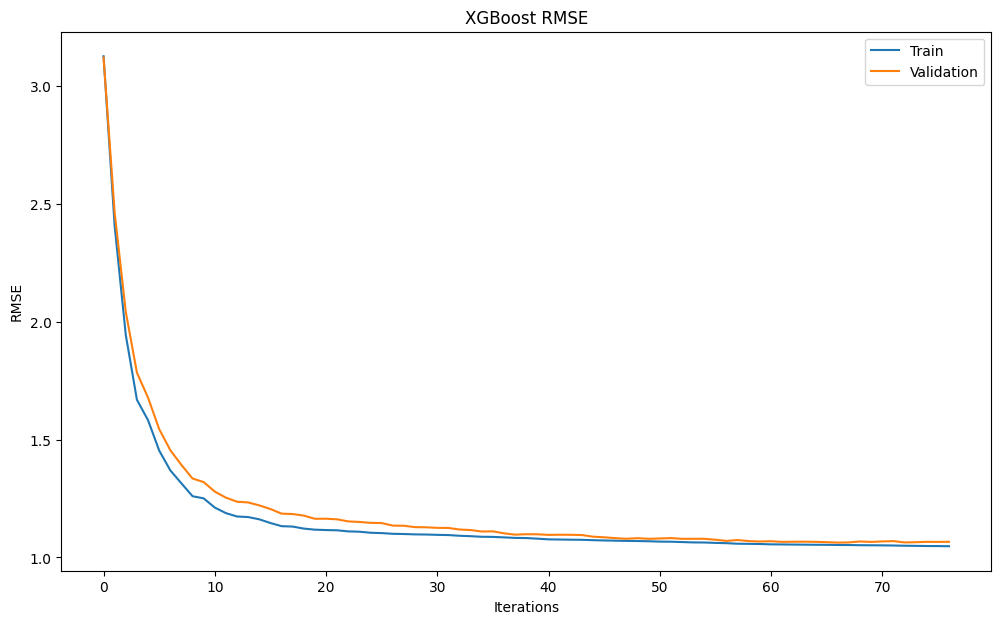

In [15]:
# Access the evaluation results
evals_result = xgb_model.evals_result()
# Plotting the RMSE for training and validation sets
epochs = len(evals_result['validation_0']['rmse'])
x_axis = range(0, epochs)
plt.figure(figsize=(12, 7))
plt.plot(x_axis, evals_result['validation_0']['rmse'], label='Train')
plt.plot(x_axis, evals_result['validation_1']['rmse'], label='Validation')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('XGBoost RMSE')
plt.show()

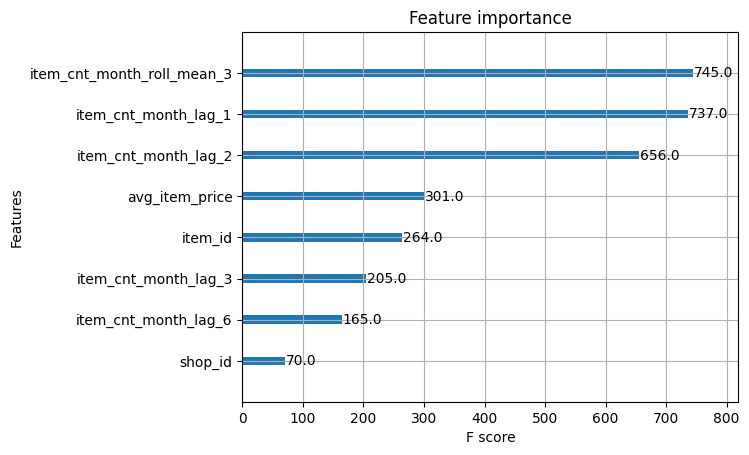

In [16]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()



In [17]:
train_set = train_set.drop(['item_cnt_month_lag_6'], axis=1)
validation_set = validation_set.drop(['item_cnt_month_lag_6'], axis=1)
test = test.drop(['item_cnt_month_lag_6'], axis=1)


In [18]:
import numpy as np
import xgboost as xgb

# Prepare the data
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
y_train = train_set['item_cnt_month']
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
y_validation = validation_set['item_cnt_month']

# Convert to DMatrix - XGBoost's optimized data structure
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_validation, label=y_validation)

# Define the model
xgb_model1 = xgb.XGBRegressor(
    objective ='reg:squarederror',
    max_depth = 8,
    n_estimators = 1000,
    min_child_weight = 300,
    colsample_bytree = 0.8,
    subsample = 0.8,
    eta = 0.3,
    seed = 42,
    eval_metric="rmse",
    reg_lambda = 0.1,  # L2 regularization
    alpha = 0.5,  # L1 regularization
    early_stopping_rounds = 10
)


# Train the model
xgb_model1.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_validation, y_validation)],
    verbose=True,
    )

# Model Evaluation (optional, for checking model performance on validation set)
y_pred_validation = xgb_model1.predict(X_validation)
rmse_validation = np.sqrt(np.mean((y_validation - y_pred_validation) ** 2))
print("RMSE 1 on Validation Set: ", rmse_validation)


[0]	validation_0-rmse:3.53457	validation_1-rmse:3.42218
[1]	validation_0-rmse:3.27054	validation_1-rmse:3.13815
[2]	validation_0-rmse:3.04826	validation_1-rmse:2.89110
[3]	validation_0-rmse:2.92591	validation_1-rmse:2.75368
[4]	validation_0-rmse:2.86281	validation_1-rmse:2.67358
[5]	validation_0-rmse:2.28654	validation_1-rmse:2.20198
[6]	validation_0-rmse:1.96804	validation_1-rmse:1.94924
[7]	validation_0-rmse:1.69747	validation_1-rmse:1.71735
[8]	validation_0-rmse:1.68377	validation_1-rmse:1.69556
[9]	validation_0-rmse:1.51772	validation_1-rmse:1.55037
[10]	validation_0-rmse:1.40508	validation_1-rmse:1.43392
[11]	validation_0-rmse:1.35608	validation_1-rmse:1.39447
[12]	validation_0-rmse:1.29690	validation_1-rmse:1.33784
[13]	validation_0-rmse:1.27524	validation_1-rmse:1.30148
[14]	validation_0-rmse:1.25127	validation_1-rmse:1.27965
[15]	validation_0-rmse:1.24322	validation_1-rmse:1.27283
[16]	validation_0-rmse:1.23041	validation_1-rmse:1.25584
[17]	validation_0-rmse:1.20848	validation

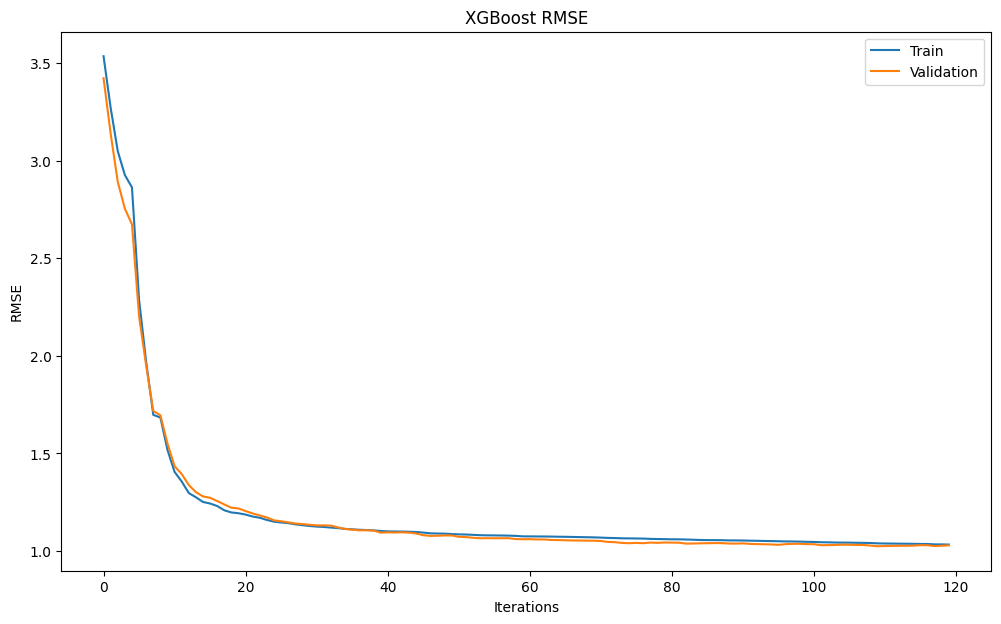

In [19]:
# Access the evaluation results
evals_result = xgb_model1.evals_result()
# Plotting the RMSE for training and validation sets
epochs = len(evals_result['validation_0']['rmse'])
x_axis = range(0, epochs)
plt.figure(figsize=(12, 7))
plt.plot(x_axis, evals_result['validation_0']['rmse'], label='Train')
plt.plot(x_axis, evals_result['validation_1']['rmse'], label='Validation')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('XGBoost RMSE')
plt.show()

In [20]:
# Make sure to reorder the columns to match the training set
X_test = test.drop(['ID', 'date_block_num', 'item_cnt_month'], axis=1)
X_test = X_test[X_train.columns]  # Reorder the columns based on the training set

# Make predictions
predictions = xgb_model1.predict(X_test)

# Post-process predictions
predictions = np.clip(predictions, 0, 20)  # Clipping to [0, 20] range

# Prepare the submission file
submission = pd.DataFrame({'ID': test['ID'], 'item_cnt_month': predictions})
submission.to_csv('submission.csv', index=False)


In [21]:
submission

,ID,item_cnt_month
0,0,10.740491
1,1,0.927900
2,2,0.475180
3,3,0.927900
4,4,0.927900
...,...,...
214195,214195,0.456023
214196,214196,0.358927
214197,214197,0.452630
214198,214198,0.358927


In [22]:
# Descriptive statistics for item_cnt_month in the validation set
validation_stats = validation_set['item_cnt_month'].describe()

# Calculate the range of item_cnt_month
item_cnt_range = validation_stats['max'] - validation_stats['min']

# Extract the standard deviation
item_cnt_std = validation_stats['std']

# Print the results
print(f"Range of item_cnt_month: {item_cnt_range}")
print(f"Standard Deviation of item_cnt_month: {item_cnt_std}")
print(f"RMSE on Validation Set: {rmse_validation}")


Range of item_cnt_month: 155.0
Standard Deviation of item_cnt_month: 3.968842464506039
RMSE on Validation Set: 1.0245366292463047


In [23]:
######################
#Cross Validation
##################



from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb

# Define your XGBoost model
xgb_modelCV = xgb.XGBRegressor(
    objective ='reg:squarederror',
    max_depth = 8,
    n_estimators = 1000,
    min_child_weight = 300,
    colsample_bytree = 0.8,
    subsample = 0.8,
    eta = 0.3,
    seed = 42,
    reg_lambda = 1,  # Use reg_lambda instead of lambda to avoid syntax issues
    alpha = 0.5
)

# Prepare your full dataset
X = monthly_sales.drop(['item_cnt_month', 'date_block_num'], axis=1)
y = monthly_sales['item_cnt_month']

# Define k-fold cross-validation parameters
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation
scores = cross_val_score(xgb_modelCV, X, y, scoring='neg_root_mean_squared_error', cv=kf)

# Print RMSE scores and their mean
print("Cross-validation RMSE scores:", -scores)
print("Mean cross-validation RMSE:", -scores.mean())


Cross-validation RMSE scores: [1.06357686 1.09455338 1.05356753 1.03824889 1.07610411]
Mean cross-validation RMSE: 1.0652101507564473
